# Neural Style Transfer

В данном ноутбуке на основе кода из семинара (а вернее <https://alexis-jacq.github.io>) будет осуществлен перенос двух разных стилей на изображение

In [ ]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

     |████████████████████████████████| 5.7MB 9.4MB/s 
     |████████████████████████████████| 112kB 45.8MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=12d0428b8ee3efb3be0e472a57868bc21e08e8f486d43bdaa5122a4a98eb41c6
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [2]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

from pylab import rcParams
rcParams['figure.figsize'] = 7,7

## Перенос двух стилей на две разные части изображения

Загружаем две картинки, с которых алгоритм будет брать стиль. Приводим эти картинки, а также все картинки далее до размера 256х256 (на 128 пикселях сложно что-то рассмотреть + как мне кажется, стиль не так четко видно, а 512 очень долго считается)

In [3]:
imsize = 256
loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

В качестве исходников для стилей я использую современный поп-арт портрет, а также картину художника Пьера Огюста Ренуара в стиле импрессионизма "Портрет актрисы Жанны Самари"

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style1_img = image_loader("popart.jpg")
style2_img = image_loader("renuar.jpg")

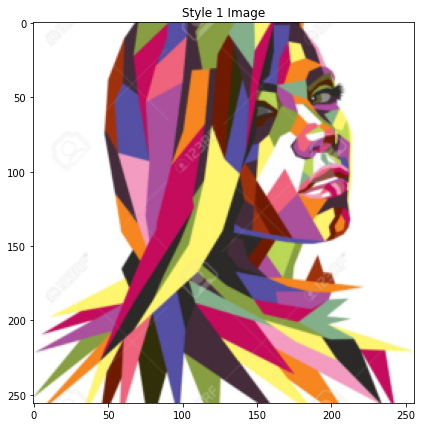

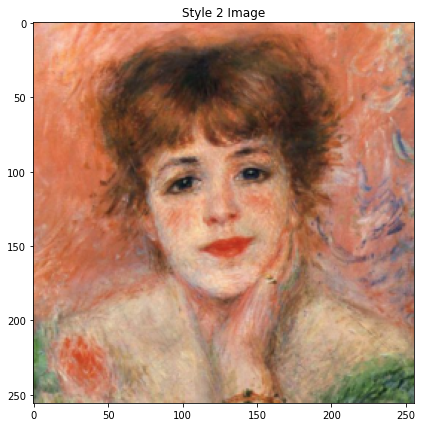

In [38]:
unloader = transforms.ToPILImage() # тензор в картинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style1_img, title='Style 1 Image')

plt.figure()
imshow(style2_img, title='Style 2 Image')

Чтобы применить разные стили к разным частям изображения, понадобится бинарная маска из нулей и единиц. Первый стиль (поп-арт) переносится на левую часть картинки, состоящую из единиц. 

Потом маску нужно инвертировать, чтобы применить второй стиль на оставшуюся правую часть, которая теперь станет белой (состоящей из единиц)

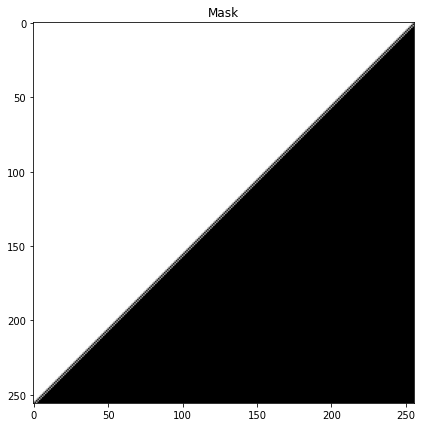

In [7]:
mask_png = image_loader("mask.png")

plt.figure()
imshow(mask_png, title='Mask')

In [8]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [9]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Определим функцию, которая преобразует размерность маски в соответствии с разномерностью выходов слоев сверточной сети, чтобы можно было их поэлементно перемножить (использованный метод из [этой статьи](http://cs231n.stanford.edu/reports/2017/pdfs/416.pdf))

In [10]:
def to_mask_multiplication(input, mask):
  mask = F.interpolate(mask, size=input.shape[2])
  mask = mask[:,0,:,:].repeat(input.shape[1], 1, 1).unsqueeze(0)
  return mask*input

Матрица Грама считается уже по перемноженному на маску тензору карт активаций. Для каждого из двух стилей будут разные матрицы Грама. Таким образом мы зануляем пиксели, на который стиль применяться не будет.

In [11]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature, mask):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something
            self.mask = mask

        def forward(self, input):
            G = gram_matrix(to_mask_multiplication(input, self.mask))
            self.loss = F.mse_loss(G, self.target)
            return input

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [13]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

По сравнению с семинарским кодом добавила несколько слоев, после которых будет считаться loss

In [14]:
content_layers_default = ['conv_5', 'conv_6']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7']

In [15]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Для каждого стиля создается свой класс StyleLoss и сохраняется в модель. В функции ниже run_style_transfer из них получаем значение лосса. Лоссы двух стилей складываются и накапливаются в общем лоссе стиля.

In [16]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style1_img, style2_img, content_img, mask_png,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style1_img).detach()
                style1_loss = StyleLoss(target_feature1, mask_png)
                model.add_module("style1_loss_{}".format(i), style1_loss)

                target_feature2 = model(style2_img).detach()
                style2_loss = StyleLoss(target_feature2, 1-mask_png) 
                model.add_module("style2_loss_{}".format(i), style2_loss)

                style_losses.append((style1_loss,style2_loss))

        #выбрасываем все уровни после последенего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [17]:
def get_input_optimizer(input_img):
        #добавляет содержимое тензора картинки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [18]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style1_img, style2_img, mask_png, input_img, num_steps=450,
                        style_weight=10000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img, mask_png)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl[0].loss
                    style_score += sl[1].loss

                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Реализуем алгоритм сначала на котиках:

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 135.777252 Content Loss: 39.516567

run [100]:
Style Loss : 60.841843 Content Loss: 42.304676

run [150]:
Style Loss : 39.595760 Content Loss: 42.603214

run [200]:
Style Loss : 27.448488 Content Loss: 41.280731

run [250]:
Style Loss : 23.343616 Content Loss: 41.101234

run [300]:
Style Loss : 114.040421 Content Loss: 52.959667

run [350]:
Style Loss : 28.428503 Content Loss: 46.767395

run [400]:
Style Loss : 18.736561 Content Loss: 43.670834

run [450]:
Style Loss : 15.671286 Content Loss: 41.652946



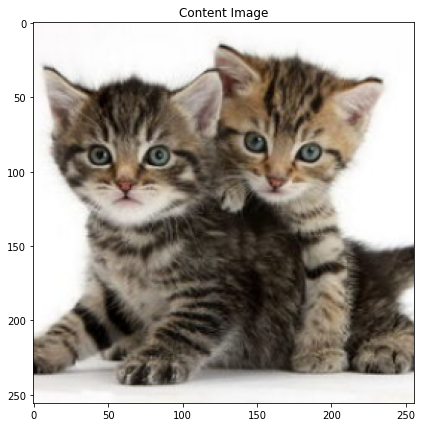

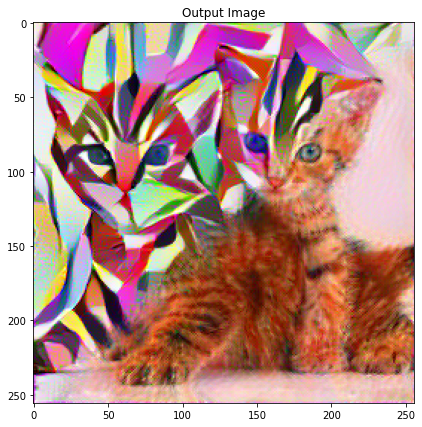

In [ ]:
content_img = image_loader("cat.jpg")

input_img = content_img.clone()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, mask_png, input_img)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Затем на фотографии еды:

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 98.537804 Content Loss: 34.258190

run [100]:
Style Loss : 46.118507 Content Loss: 35.208683

run [150]:
Style Loss : 31.668194 Content Loss: 35.893505

run [200]:
Style Loss : 24.527721 Content Loss: 34.887684

run [250]:
Style Loss : 20.583168 Content Loss: 34.681656

run [300]:
Style Loss : 258.303497 Content Loss: 56.382198

run [350]:
Style Loss : 28.559330 Content Loss: 44.078098

run [400]:
Style Loss : 18.530405 Content Loss: 38.831772

run [450]:
Style Loss : 15.634320 Content Loss: 35.739864



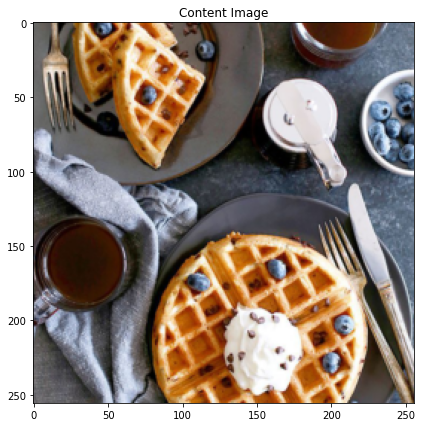

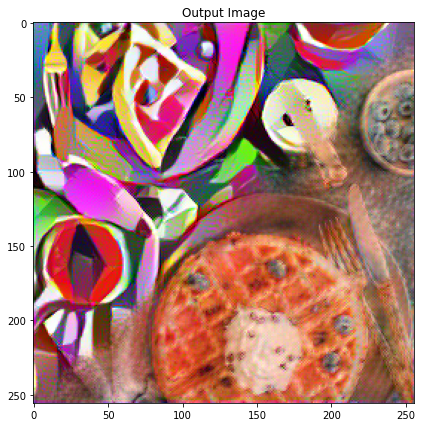

In [ ]:
content_img = image_loader("food.jpg")

input_img = content_img.clone()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, mask_png, input_img)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

И на кадре из фильма с изображением людей:

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 120.860779 Content Loss: 38.334064

run [100]:
Style Loss : 52.671909 Content Loss: 39.120552

run [150]:
Style Loss : 124.742035 Content Loss: 50.036514

run [200]:
Style Loss : 31.863306 Content Loss: 43.180359

run [250]:
Style Loss : 21.415600 Content Loss: 40.405689

run [300]:
Style Loss : 18.159256 Content Loss: 38.760059

run [300]:
Style Loss : 18.159256 Content Loss: 38.760059

run [350]:
Style Loss : 17.702339 Content Loss: 38.244450

run [400]:
Style Loss : 46.417000 Content Loss: 36.767773

run [450]:
Style Loss : 190.520126 Content Loss: 54.315117



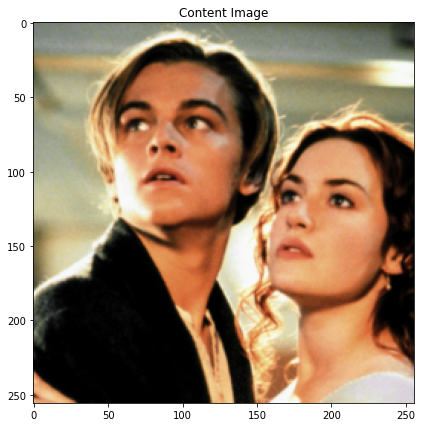

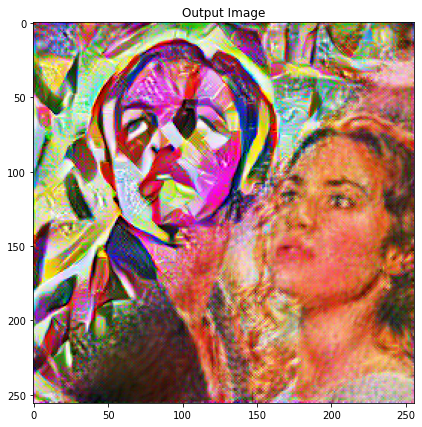

In [ ]:
content_img = image_loader("people.jpg")

input_img = content_img.clone()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, mask_png, input_img)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

# Одновременный перенос двух стилей

Теперь нам не нужна маска, поэтому нужно переопределить класс StyleLoss (убрать оттуда умножение на маску)

In [19]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

Также соответственно меняем функции get_style_model_and_losses и run_style_transfer (как минимум у них меняется количество аргументов)

In [20]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style1_img, style2_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style1_img).detach()
                style1_loss = StyleLoss(target_feature1)
                model.add_module("style1_loss_{}".format(i), style1_loss)

                target_feature2 = model(style2_img).detach()
                style2_loss = StyleLoss(target_feature2) 
                model.add_module("style2_loss_{}".format(i), style2_loss)

                style_losses.append((style1_loss,style2_loss))

        #выбрасываем все уровни после последенего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [40]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style1_img, style2_img, input_img, num_steps=450,
                       style_weight=10000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl[0].loss*0.4
                    style_score += sl[1].loss*0.6

                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Попробуем смешать стили для тех же трех картинок: коты, еда и кадр из Титаника

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 1389.497925 Content Loss: 84.949677

run [100]:
Style Loss : 1381.747437 Content Loss: 81.457153

run [150]:
Style Loss : 1379.577515 Content Loss: 79.791481

run [200]:
Style Loss : 1378.952759 Content Loss: 78.920448

run [250]:
Style Loss : 1378.568237 Content Loss: 78.383057

run [300]:
Style Loss : 1378.219116 Content Loss: 78.135170

run [350]:
Style Loss : 1378.090088 Content Loss: 77.880058

run [400]:
Style Loss : 1381.288940 Content Loss: 87.225525

run [450]:
Style Loss : 1378.527588 Content Loss: 80.813324



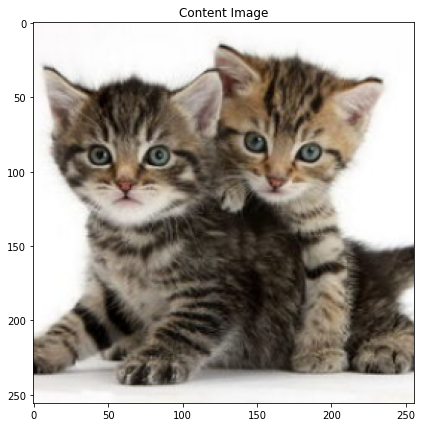

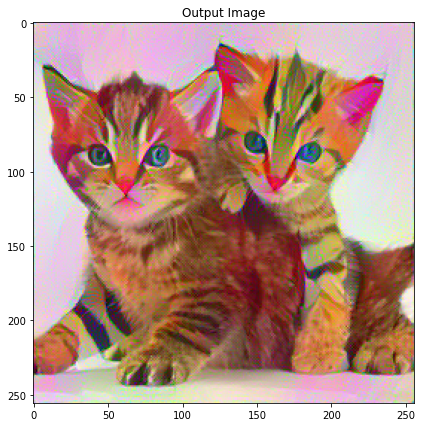

In [41]:
content_img = image_loader("cat.jpg")

input_img = content_img.clone()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, input_img)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Оба стиля применились слабо, но все-таки прослеживаются: от поп-арта перенеслись яркие неоновые цвета и геометрические фигуры (хорошо видно в районе лба кошечек), а импрессионизм проявляется в розовом цвете и в небольшой фактурности шерсти.

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 1411.457397 Content Loss: 116.942169

run [100]:
Style Loss : 1390.800781 Content Loss: 70.134590

run [150]:
Style Loss : 1385.381348 Content Loss: 57.167328

run [200]:
Style Loss : 1382.917114 Content Loss: 52.012226

run [250]:
Style Loss : 1381.553467 Content Loss: 49.366875

run [300]:
Style Loss : 1380.673096 Content Loss: 47.699814

run [350]:
Style Loss : 1380.065918 Content Loss: 46.605225

run [400]:
Style Loss : 1379.620483 Content Loss: 45.833530

run [450]:
Style Loss : 1379.262695 Content Loss: 45.254837



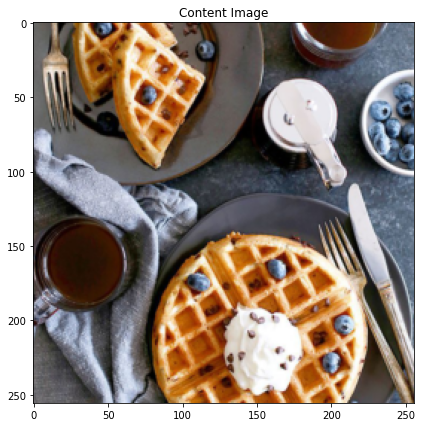

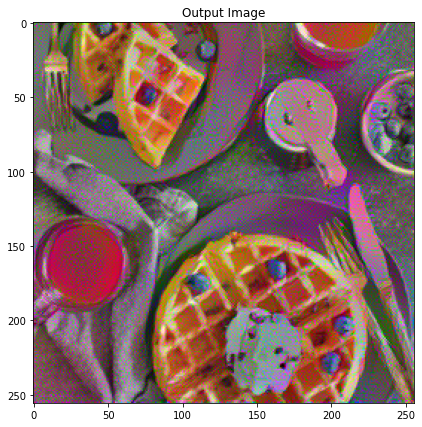

In [42]:
content_img = image_loader("food.jpg")

input_img = torch.randn(content_img.data.size(), device=device)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, input_img)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 1406.435669 Content Loss: 111.216782

run [100]:
Style Loss : 1385.418823 Content Loss: 67.893906

run [150]:
Style Loss : 1380.059570 Content Loss: 54.885201

run [200]:
Style Loss : 1377.862427 Content Loss: 49.328045

run [250]:
Style Loss : 1376.816284 Content Loss: 46.607300

run [300]:
Style Loss : 1376.733765 Content Loss: 44.857334

run [350]:
Style Loss : 1375.742432 Content Loss: 44.210331

run [400]:
Style Loss : 1375.425171 Content Loss: 43.496246

run [450]:
Style Loss : 1375.157593 Content Loss: 42.948292



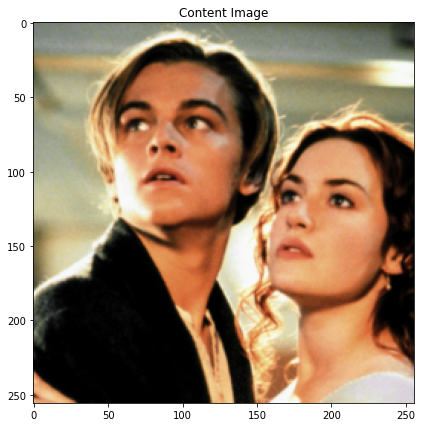

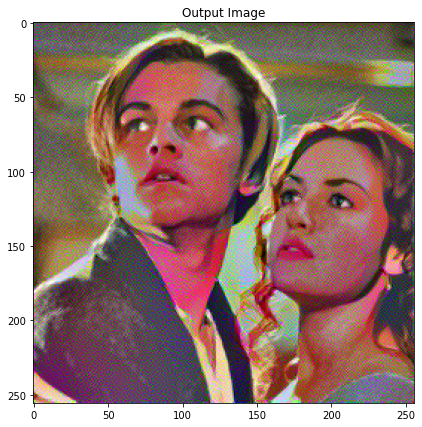

In [43]:
content_img = image_loader("people.jpg")

input_img = torch.randn(content_img.data.size(), device=device)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, input_img)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Так же, как и в случае, с котами, оба стиля проявляются достаточно слабо. Но в целом, стили являются почти противоположными : один - резкий, крупные детали, и яркий, другой - сдержанные цвета и мелкие штрихи. Поэтому, возможно, что они просто перебивают друг друга, что, в целом, неплохо, потому что результаты очень красивые!